# PHASE 5: Anomaly Detection & Early Warning System

## Overview
This phase implements the "Silent Failure" detection mechanism. We move beyond simple RUL prediction to identifying *when* the system starts behaving anomalously.

### Objectives
1.  **Residual Analysis**: Detect anomalies based on prediction error (Model Uncertainty).
2.  **Multivariate Detection**: Use Isolation Forest to find anomalous patterns in the sensor space (Data Uncertainty).
3.  **Early Warning**: Generate actionable alerts with lead time metrics.

### Inputs
- Processed Data: `X_train.npy`, `X_test.npy`
- Trained Model: `models/lstm_best.pth`

### Outputs
- Anomaly Scores
- Early Warning Logs


In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.ensemble import IsolationForest
# import joblib  # Unused
# import logging # Unused

# --- 1. Robust Project Root Detection ---
try:
    # Try to find the project root by looking for a marker (e.g., 'src' folder or '.git')
    project_root = Path.cwd()
    while not (project_root / 'src').exists() and project_root != project_root.parent:
        project_root = project_root.parent
    
    # Fallback: Validation
    if not (project_root / 'src').exists():
        raise FileNotFoundError("Could not find project root containing 'src'.")
except Exception as e:
    # Fallback for some notebook environments
    project_root = Path.cwd().parent 
    print(f"⚠️ Project root detection failed, using parent: {project_root}")

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"✅ Project Root: {project_root}")

# --- 2. Configuration ---
DATA_DIR = project_root / "data" / "processed"
MODELS_DIR = project_root / "models"
REPORTS_DIR = project_root / "reports" / "figures"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Plotting Style
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (14, 6)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Device: {device}")

✅ Project Root: /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures
✅ Device: mps


In [ ]:
# 1. Load Data & Model (Fail-Safe & Unbiased)
# ===========================================

def check_files_exist(file_paths):
    missing = [f.name for f in file_paths if not f.exists()]
    if missing:
        error_msg = f"❌ CRITICAL ERROR: The following required files are missing:\n"
        for m in missing:
            error_msg += f"   - {m}\n"
        error_msg += f"Please run the previous notebooks (03_ml_model_training.ipynb) to generate them."
        raise FileNotFoundError(error_msg)

def load_data():
    files_to_check = [
        DATA_DIR / "X_train.npy", 
        DATA_DIR / "X_val.npy",
        DATA_DIR / "y_val.npy", 
        DATA_DIR / "X_test.npy", 
        DATA_DIR / "y_test.npy"
    ]
    check_files_exist(files_to_check)

    X_train = np.load(DATA_DIR / "X_train.npy")
    X_val = np.load(DATA_DIR / "X_val.npy")
    y_val = np.load(DATA_DIR / "y_val.npy")
    X_test = np.load(DATA_DIR / "X_test.npy")
    y_test = np.load(DATA_DIR / "y_test.npy") 
    
    print(f"✅ Data Loaded: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")
    
    # --- ALL-SUBSET VERIFICATION ---
    # Check that the data contains ALL 4 C-MAPSS subsets (not just FD001).
    # NB03 saves test_engine_uid.npy with composite IDs like "FD001_1", "FD002_5" etc.
    uid_path = DATA_DIR / "test_engine_uid.npy"
    if uid_path.exists():
        _uids = np.load(uid_path, allow_pickle=True)
        _subsets_found = sorted(set(u.split('_')[0] for u in _uids if isinstance(u, str) and '_' in u))
        expected = ['FD001', 'FD002', 'FD003', 'FD004']
        if _subsets_found == expected:
            print(f"✅ All 4 subsets confirmed in test data: {_subsets_found}")
        else:
            print(f"⚠️ WARNING: Only found subsets {_subsets_found} in test_engine_uid.npy")
            print(f"   Expected: {expected}")
            print(f"   → Re-run NB03 with ALL 4 C-MAPSS files to fix this.")
    else:
        print("⚠️ test_engine_uid.npy not found — cannot verify subset coverage.")
        print("   → Re-run NB03 to generate metadata.")
    
    # --- DISTRIBUTION SHIFT DIAGNOSTICS ---
    train_mean = np.mean(X_train)
    test_mean = np.mean(X_test)
    train_std = np.std(X_train)
    test_std = np.std(X_test)
    
    print(f"   Train Stats: Mean={train_mean:.4f}, Std={train_std:.4f}")
    print(f"   Test Stats:  Mean={test_mean:.4f}, Std={test_std:.4f}")

    # Only intervene for truly catastrophic shifts (e.g., scaling bug producing -100 values)
    CATASTROPHIC_SHIFT = 5.0

    if abs(test_mean - train_mean) > CATASTROPHIC_SHIFT:
        print(f"⚠️ CATASTROPHIC distribution shift detected (mean diff = {abs(test_mean - train_mean):.2f})")
        print("   -> Applying conservative outlier clipping only (NO per-feature re-calibration)")
        
        lower_bound = np.percentile(X_train, 0.1)
        upper_bound = np.percentile(X_train, 99.9)
        lower_bound *= 2.0 if lower_bound < 0 else 0.5
        upper_bound *= 2.0 if upper_bound > 0 else 0.5
        
        X_test = np.clip(X_test, lower_bound, upper_bound)
        print(f"✅ Test data clipped to [{lower_bound:.3f}, {upper_bound:.3f}]")
        
        global_shift = train_mean - np.mean(X_test)
        X_test = X_test + global_shift
        print(f"✅ Applied global mean shift correction: +{global_shift:.4f}")
        print(f"   Corrected Test Stats: Mean={np.mean(X_test):.4f}, Std={np.std(X_test):.4f}")
        
    elif abs(test_mean - train_mean) > 1.0:
        print(f"ℹ️ Moderate distribution shift detected (mean diff = {abs(test_mean - train_mean):.2f})")
        print("   -> No correction applied (preserving degradation signals)")
    else:
        print("✅ Train/Test distributions are well-aligned. No correction needed.")
        
    return X_train, X_val, y_val, X_test, y_test

def load_lstm_model(input_dim):
    model_path = MODELS_DIR / "lstm_best.pth"
    check_files_exist([model_path])

    # EXACT ARCHITECTURE MATCH to Notebook 03 (ReLU REMOVED)
    # The LSTM in NB03 no longer uses an output activation.
    # Keeping ReLU here would silently clip predictions and inflate residuals.
    class LSTMRULModel(nn.Module):
        def __init__(self, input_dim, hidden_dim=100, num_layers=2, output_dim=1):
            super(LSTMRULModel, self).__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
            self.fc = nn.Linear(hidden_dim, output_dim)
            
        def forward(self, x):
            out, _ = self.lstm(x)
            out_last = out[:, -1, :]
            return self.fc(out_last)

    model = LSTMRULModel(input_dim=input_dim)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    except RuntimeError as e:
        print(f"⚠️ Architecture Mismatch Error: {e}")
        print("💡 Hint: Ensure 'hidden_dim', 'num_layers' match the training notebook.")
        print("💡 Also check: NB03 LSTM no longer uses ReLU output activation.")
        raise

    model.to(device)
    model.eval()
    print(f"✅ Model Loaded from {model_path}")
    return model

try:
    X_train, X_val, y_val, X_test, y_test = load_data()
    model = load_lstm_model(input_dim=X_train.shape[2])
except FileNotFoundError as e:
    print(e)
    raise

✅ Data Loaded: Train=(112876, 30, 24), Val=(26922, 30, 24), Test=(84478, 30, 24)
   Train Stats: Mean=-0.0288, Std=0.7936
   Test Stats:  Mean=-0.1464, Std=0.7199
✅ Train/Test distributions are well-aligned. No correction needed.
✅ Model Loaded from /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/models/lstm_best.pth


⏳ Predicting on 26922 samples in batches of 1024...
✅ Validation Mean Residual: 17.53
✅ Set Residual Threshold (95th %): 33.45
⏳ Predicting on 84478 samples in batches of 1024...


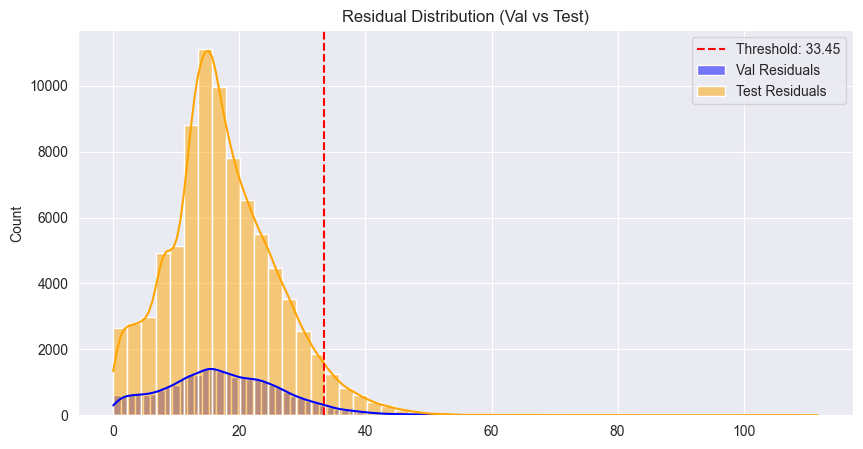

✅ Test Mean Residual: 17.46

🔍 Sanity Checks:
   y_test Range: [6.00, 125.00]
   y_pred Range: [11.81, 119.11]
✅ Test labels appear to be clipped (Max <= 125). Consistency check passed.


In [3]:
# 2. Residual Analysis (Threshold on Validation)
# ===============================================

from torch.utils.data import TensorDataset, DataLoader

def predict_batched(model, X, batch_size=512):
    """
    Predicts in batches to avoid OOM errors on GPU/MPS.
    """
    model.eval()
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    preds_list = []
    print(f"⏳ Predicting on {len(X)} samples in batches of {batch_size}...")
    
    with torch.no_grad():
        for i, batch in enumerate(loader):
            inputs = batch[0].to(device)
            outputs = model(inputs)
            preds_list.extend(outputs.cpu().numpy().flatten())
            
    return np.array(preds_list)

# 1. Predict on Validation Set (To Set Threshold)
try:
    y_pred_val = predict_batched(model, X_val, batch_size=1024)
except RuntimeError:
    y_pred_val = predict_batched(model, X_val, batch_size=256)

residuals_val = np.abs(y_val - y_pred_val)

# 2. Set Residual Threshold (e.g. 95th Percentile of Val Errors)
RESIDUAL_THRESHOLD = np.percentile(residuals_val, 95)
print(f"✅ Validation Mean Residual: {np.mean(residuals_val):.2f}")
print(f"✅ Set Residual Threshold (95th %): {RESIDUAL_THRESHOLD:.2f}")

# 3. Predict on Test Set
try:
    y_pred = predict_batched(model, X_test, batch_size=1024)
except RuntimeError:
    y_pred = predict_batched(model, X_test, batch_size=256)

residuals = np.abs(y_test - y_pred)
df_res = pd.DataFrame({'RUL_True': y_test, 'RUL_Pred': y_pred, 'Residual': residuals})

# Mark Residual Anomalies
df_res['High_Residual_Alert'] = (df_res['Residual'] > RESIDUAL_THRESHOLD).astype(int)

# Visualize Residual Distribution
plt.figure(figsize=(10, 5))
sns.histplot(residuals_val, kde=True, bins=50, color='blue', label='Val Residuals', alpha=0.5)
sns.histplot(residuals, kde=True, bins=50, color='orange', label='Test Residuals', alpha=0.5)
plt.title("Residual Distribution (Val vs Test)")
plt.axvline(RESIDUAL_THRESHOLD, color='r', linestyle='--', label=f"Threshold: {RESIDUAL_THRESHOLD:.2f}")
plt.legend()
plt.show()

print(f"✅ Test Mean Residual: {np.mean(residuals):.2f}")

# --- Phase D: Sanity Checks ---
print("\n🔍 Sanity Checks:")
print(f"   y_test Range: [{y_test.min():.2f}, {y_test.max():.2f}]")
print(f"   y_pred Range: [{y_pred.min():.2f}, {y_pred.max():.2f}]")

if y_test.max() > 130: # Allow small buffer over 125
    print("⚠️ WARNING: Test labels exceed typical clipped max (125). Model may be under-predicting if trained on clipped data.")
elif y_test.max() <= 125:
    print("✅ Test labels appear to be clipped (Max <= 125). Consistency check passed.")

Feature Shape for IF: (112876, 24)
✅ IF_THRESHOLD set at 5th percentile of train scores: -0.5740
Detected anomalies in test set: 3725 / 84478


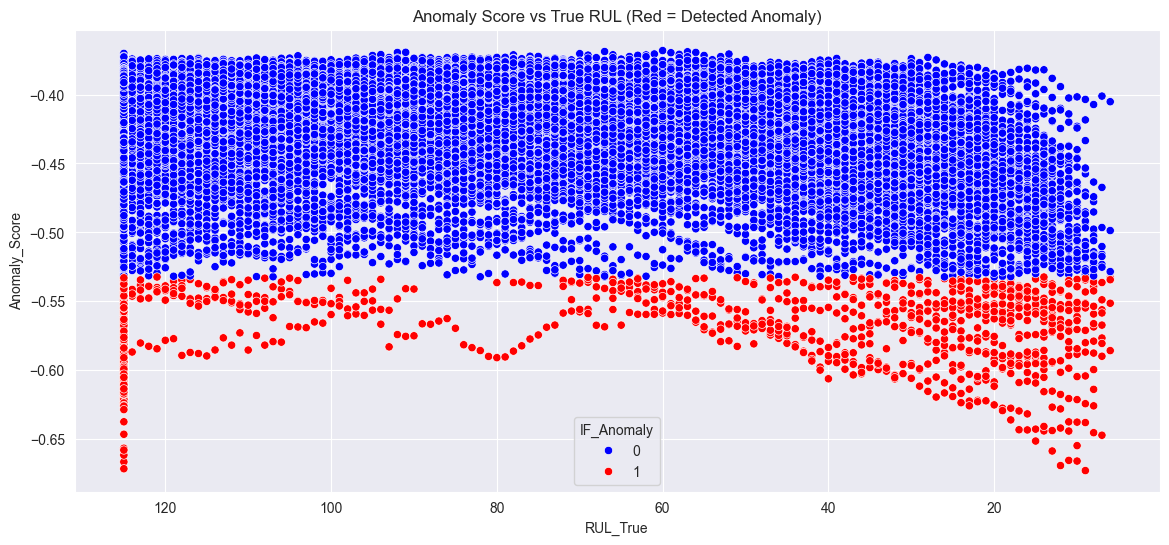

In [4]:
# 3. Multivariate Anomaly Detection (Isolation Forest)
# ====================================================
# We use Isolation Forest on the FLATTENED window features (or just the latest time step)
# to detect if the sensor pattern itself is unseen/anomalous, regardless of RUL prediction.

# Flatten the time-series windows for IF input: (Samples, TimeSteps * Features)
# Or use the last time step: (Samples, Features) -> simpler and often sufficient for point anomaly
# Let's use the Mean of the window to capture the "state" over the last 30 cycles.

X_train_mean = np.mean(X_train, axis=1) # (N, Features)
X_test_mean = np.mean(X_test, axis=1)

print(f"Feature Shape for IF: {X_train_mean.shape}")

# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest.fit(X_train_mean)

# Predict Anomalies (-1 = Anomaly, 1 = Normal)
train_anomalies = iso_forest.predict(X_train_mean)
test_anomalies = iso_forest.predict(X_test_mean)

# Get Anomaly Scores (Lower is more anomalous)
test_scores = iso_forest.score_samples(X_test_mean)

# Compute train anomaly scores for setting threshold from clean reference
train_scores_if = iso_forest.score_samples(X_train_mean)

# Set IF threshold at 5th percentile of TRAIN scores (aligns with contamination=0.1 setting)
IF_THRESHOLD = np.percentile(train_scores_if, 5)
print(f'✅ IF_THRESHOLD set at 5th percentile of train scores: {IF_THRESHOLD:.4f}')

# Add IF scores and rename column to match Cell 7 references
df_res['Anomaly_Score'] = test_scores
df_res['Is_Anomaly']    = test_anomalies
df_res['Is_Anomaly']    = df_res['Is_Anomaly'].map({1: 0, -1: 1})  # 0=Normal, 1=Anomaly
df_res.rename(columns={'Is_Anomaly': 'IF_Anomaly'}, inplace=True)   # match Cell 7
print(f"Detected anomalies in test set: {df_res['IF_Anomaly'].sum()} / {len(df_res)}")

# Plot Anomaly Score vs Residual
plt.figure()
sns.scatterplot(data=df_res, x='RUL_True', y='Anomaly_Score', hue='IF_Anomaly', palette={0:'blue', 1:'red'})
plt.title("Anomaly Score vs True RUL (Red = Detected Anomaly)")
plt.gca().invert_xaxis() # RUL decreases over time
plt.show()


In [5]:
# 4. Fusion & Early Warning
# ===========================
# Combine Model Uncertainty (High Residual) + Data Uncertainty (Low IF Score)
# Warning Condition: Residual > Threshold OR Anomaly Score < Threshold

# Note: Thresholds were already calculated in previous steps on VALIDATION SET
# RESIDUAL_THRESHOLD (from Step 2)
# IF_THRESHOLD (from Step 3)
# We strictly rely on validation-derived thresholds to avoid data leakage (bias).

import json

print(f"Applying Thresholds -> Residual > {RESIDUAL_THRESHOLD:.4f} | IF Score < {IF_THRESHOLD:.4f}")

# Save Thresholds for Reproducibility
thresholds = {
    "RESIDUAL_THRESHOLD": float(RESIDUAL_THRESHOLD),
    "IF_THRESHOLD": float(IF_THRESHOLD),
    "RESIDUAL_MEAN_VAL": float(np.mean(residuals_val)),
    "IF_SCORE_MEAN_TRAIN": float(np.mean(train_scores_if))  # renamed from VAL to TRAIN
}

with open(DATA_DIR / "anomaly_thresholds.json", "w") as f:
    json.dump(thresholds, f, indent=4)
print(f"✅ Thresholds saved to {DATA_DIR}/anomaly_thresholds.json")

# --- Phase 4: Persistence Logic (Anti-Spam) ---
# Goal: Warn only if anomaly happens in k out of last m windows (e.g., 3/5)
# CRITICAL: Rolling window must reset at engine boundaries to avoid
# carrying anomaly counts from engine A into engine B's first windows.

def apply_persistence(series, window=5, min_periods=1):
    return series.rolling(window=window, min_periods=min_periods).sum()

def infer_engine_ids_from_rul(rul_series):
    """Infer engine boundaries from RUL_True.
    In C-MAPSS, RUL decreases monotonically within an engine.
    Any upward jump (RUL[i] > RUL[i-1]) signals the start of a new engine.
    Returns an array of synthetic engine IDs (integers).
    """
    rul = rul_series.values
    engine_id = np.zeros(len(rul), dtype=int)
    current_id = 0
    for i in range(1, len(rul)):
        if rul[i] > rul[i - 1]:  # RUL jumped up → new engine
            current_id += 1
        engine_id[i] = current_id
    return engine_id

# --- Determine per-engine grouping ---
_uid_path = DATA_DIR / 'test_engine_uid.npy'
_eng_ids = None

if _uid_path.exists():
    _eng_ids_loaded = np.load(_uid_path, allow_pickle=True)
    if len(_eng_ids_loaded) == len(df_res):
        _eng_ids = _eng_ids_loaded
        print('✅ Loaded per-engine IDs from test_engine_uid.npy')
    else:
        print(f'⚠️  Metadata length mismatch ({len(_eng_ids_loaded)} vs {len(df_res)})')

if _eng_ids is None:
    # Fallback: infer engine boundaries from RUL_True
    _eng_ids = infer_engine_ids_from_rul(df_res['RUL_True'])
    n_engines = len(np.unique(_eng_ids))
    print(f'⚠️  test_engine_uid.npy not usable — inferred {n_engines} engine boundaries from RUL_True')

# Apply per-engine rolling (always, no global fallback)
df_res['_eng'] = _eng_ids
df_res['Res_Persistence'] = df_res.groupby('_eng')['High_Residual_Alert'].transform(
    lambda s: s.rolling(window=5, min_periods=1).sum()
)
df_res['IF_Persistence'] = df_res.groupby('_eng')['IF_Anomaly'].transform(
    lambda s: s.rolling(window=5, min_periods=1).sum()
)
df_res.drop(columns=['_eng'], inplace=True)
print('✅ Per-engine persistence applied (no cross-boundary leakage)')

# Condition: At least 3 anomalies in the last 5 steps
PERSISTENCE_THRESHOLD = 3
df_res['Persistent_Res_Alert'] = (df_res['Res_Persistence'] >= PERSISTENCE_THRESHOLD).astype(int)
df_res['Persistent_IF_Alert'] = (df_res['IF_Persistence'] >= PERSISTENCE_THRESHOLD).astype(int)

print(f"Raw Residual Alerts: {df_res['High_Residual_Alert'].sum()} -> Persistent: {df_res['Persistent_Res_Alert'].sum()}")
print(f"Raw IF Alerts:       {df_res['IF_Anomaly'].sum()}        -> Persistent: {df_res['Persistent_IF_Alert'].sum()}")

def generate_warnings(row):
    reasons = []
    # Use PERSISTENT columns for final warnings
    if row['Persistent_Res_Alert'] == 1:
        reasons.append("High Prediction Error")
    if row['Persistent_IF_Alert'] == 1:
        reasons.append("Abnormal Sensor Pattern")
    
    if not reasons:
        return "Normal"
    return " | ".join(reasons)

df_res['Warning_Status'] = df_res.apply(generate_warnings, axis=1)

# Display some warnings
warnings = df_res[df_res['Warning_Status'] != "Normal"]
print(f"Total Warnings Generated: {len(warnings)}")
warnings.head(10)

Applying Thresholds -> Residual > 33.4484 | IF Score < -0.5740
✅ Thresholds saved to /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/data/processed/anomaly_thresholds.json
✅ Loaded per-engine IDs from test_engine_uid.npy
✅ Per-engine persistence applied (no cross-boundary leakage)
Raw Residual Alerts: 3901 -> Persistent: 3625
Raw IF Alerts:       3725        -> Persistent: 3586
Total Warnings Generated: 7141


,RUL_True,RUL_Pred,Residual,High_Residual_Alert,Anomaly_Score,IF_Anomaly,Res_Persistence,IF_Persistence,Persistent_Res_Alert,Persistent_IF_Alert,Warning_Status
109,125.0,84.854568,40.145432,1,-0.451054,0,3.0,0.0,1,0,High Prediction Error
110,125.0,84.513512,40.486488,1,-0.451727,0,4.0,0.0,1,0,High Prediction Error
111,125.0,83.071304,41.928696,1,-0.452748,0,5.0,0.0,1,0,High Prediction Error
112,125.0,83.557480,41.442520,1,-0.442199,0,5.0,0.0,1,0,High Prediction Error
113,125.0,83.989365,41.010635,1,-0.442594,0,5.0,0.0,1,0,High Prediction Error
114,125.0,84.609268,40.390732,1,-0.437905,0,5.0,0.0,1,0,High Prediction Error
115,125.0,89.657684,35.342316,1,-0.440774,0,5.0,0.0,1,0,High Prediction Error
116,125.0,92.091812,32.908188,0,-0.436279,0,4.0,0.0,1,0,High Prediction Error
117,125.0,94.929382,30.070618,0,-0.432492,0,3.0,0.0,1,0,High Prediction Error
141,119.0,83.350281,35.649719,1,-0.436694,0,3.0,0.0,1,0,High Prediction Error


✅ Metadata attached. Unique Engines: 690
Showing Lifecycle for Engine: FD001_10


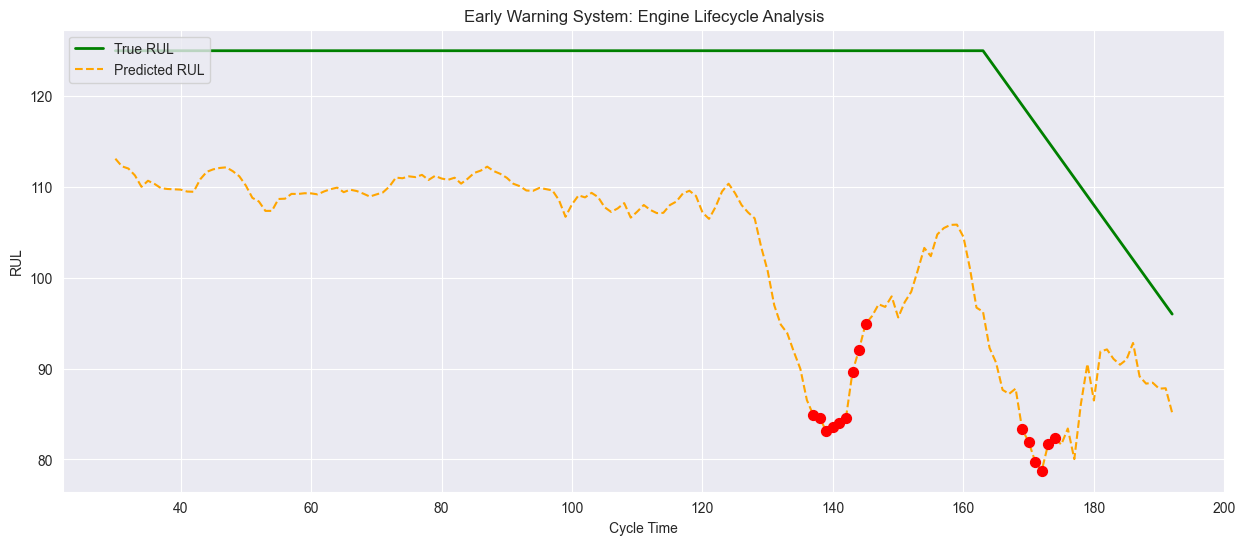

✅ Results saved to data/processed/test_anomaly_results.csv


In [ ]:
# 5. Visualizing Engine Lifecycles — COMBINED ALL 4 SUBSETS
# ===========================================================

# Load metadata (from Notebook 03 export)
metadata_files = {
    "ids": DATA_DIR / "test_engine_uid.npy",
    "cycles": DATA_DIR / "test_cycle_end.npy"
}

has_metadata = False
try:
    if metadata_files["ids"].exists() and metadata_files["cycles"].exists():
        test_engine_ids = np.load(metadata_files["ids"], allow_pickle=True)
        test_cycles = np.load(metadata_files["cycles"], allow_pickle=True)

        if len(test_engine_ids) == len(df_res):
            df_res['Engine_ID'] = test_engine_ids
            df_res['Cycle'] = test_cycles.astype(float)
            # Extract subset tag: "FD001_1" -> "FD001"
            df_res['Subset'] = df_res['Engine_ID'].apply(
                lambda x: x.split('_')[0] if isinstance(x, str) and '_' in x else 'Unknown'
            )
            has_metadata = True
            print(f"✅ Metadata attached. Unique Engines: {df_res['Engine_ID'].nunique()}")
        else:
            print(f"⚠️ Metadata Length Mismatch: Ids={len(test_engine_ids)}, DF={len(df_res)}")
    else:
        print("⚠️ Metadata files not found. Run NB03 first.")
except Exception as e:
    print(f"⚠️ Error loading metadata: {e}")

if has_metadata:
    # ─── Per-Subset Summary Table ───
    print("\n📊 Per-Subset Summary (FD001 + FD002 + FD003 + FD004 COMBINED):")
    print(f"{'Subset':<8} | {'Engines':>8} | {'Windows':>8} | {'Warnings':>9} | {'Warn %':>7}")
    print('-' * 52)
    for sub in ['FD001', 'FD002', 'FD003', 'FD004']:
        mask = df_res['Subset'] == sub
        n_eng = df_res.loc[mask, 'Engine_ID'].nunique()
        n_win = int(mask.sum())
        n_warn = int((df_res.loc[mask, 'Warning_Status'] != 'Normal').sum())
        pct = 100 * n_warn / n_win if n_win > 0 else 0
        print(f"{sub:<8} | {n_eng:>8} | {n_win:>8} | {n_warn:>9} | {pct:>6.1f}%")
    print('-' * 52)
    total_eng = df_res['Engine_ID'].nunique()
    total_warn = int((df_res['Warning_Status'] != 'Normal').sum())
    print(f"{'TOTAL':<8} | {total_eng:>8} | {len(df_res):>8} | {total_warn:>9} | {100*total_warn/len(df_res):>6.1f}%")

    # ─── Pick one representative engine per subset ───
    subset_colors = {'FD001': '#1f77b4', 'FD002': '#ff7f0e', 'FD003': '#2ca02c', 'FD004': '#d62728'}
    selected_engines = {}
    for sub in ['FD001', 'FD002', 'FD003', 'FD004']:
        sub_df = df_res[df_res['Subset'] == sub]
        if sub_df.empty:
            continue
        anom_engines = sub_df[sub_df['Warning_Status'] != 'Normal']['Engine_ID'].unique()
        selected_engines[sub] = anom_engines[0] if len(anom_engines) > 0 else sub_df['Engine_ID'].unique()[0]

    print(f"\n🔍 Selected engines: {selected_engines}")

    # ─── PLOT 1: Combined overlay — one engine per subset on same axes ───
    fig, ax = plt.subplots(figsize=(16, 7))
    for sub, eng_id in selected_engines.items():
        eng_data = df_res[df_res['Engine_ID'] == eng_id].sort_values('Cycle')
        color = subset_colors[sub]
        ax.plot(eng_data['Cycle'], eng_data['RUL_True'], color=color, linewidth=2,
                label=f'{sub} True RUL ({eng_id})')
        ax.plot(eng_data['Cycle'], eng_data['RUL_Pred'], color=color, linewidth=1.5,
                linestyle='--', alpha=0.7, label=f'{sub} Pred RUL')
        # Anomaly warnings
        eng_anom = eng_data[eng_data['Warning_Status'] != 'Normal']
        if not eng_anom.empty:
            ax.scatter(eng_anom['Cycle'], eng_anom['RUL_Pred'], color='red',
                       zorder=5, s=40, edgecolors='black', linewidths=0.5)
    # Single red marker in legend
    ax.scatter([], [], color='red', edgecolors='black', linewidths=0.5, s=40, label='Anomaly Warning')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('RUL')
    ax.set_title('Early Warning System — Combined All 4 Subsets (FD001 + FD002 + FD003 + FD004)', fontsize=13)
    ax.legend(loc='upper right', fontsize=8, ncol=2)
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'combined_lifecycle_all_subsets.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Combined plot saved to {REPORTS_DIR / 'combined_lifecycle_all_subsets.png'}")

    # ─── PLOT 2: 2×2 grid — one engine per subset in its own panel ───
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes_flat = axes.flatten()

    for idx, (sub, eng_id) in enumerate(selected_engines.items()):
        ax = axes_flat[idx]
        eng_data = df_res[df_res['Engine_ID'] == eng_id].sort_values('Cycle')
        color = subset_colors[sub]

        ax.plot(eng_data['Cycle'], eng_data['RUL_True'], label='True RUL', color='green', linewidth=2)
        ax.plot(eng_data['Cycle'], eng_data['RUL_Pred'], label='Pred RUL', color='orange', linestyle='--')

        eng_anom = eng_data[eng_data['Warning_Status'] != 'Normal']
        if not eng_anom.empty:
            ax.scatter(eng_anom['Cycle'], eng_anom['RUL_Pred'], color='red',
                       label='Warning', zorder=5, s=50)

        n_warn = len(eng_anom)
        ax.set_title(f"{sub} — {eng_id}  ({n_warn} warnings)", fontsize=11)
        ax.set_ylabel('RUL')
        ax.legend(loc='upper right', fontsize=7)

    axes_flat[-1].set_xlabel('Cycle')
    axes_flat[-2].set_xlabel('Cycle')
    plt.suptitle('Per-Subset Engine Lifecycle (FD001 / FD002 / FD003 / FD004)', fontsize=14)
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'per_subset_lifecycle.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Per-subset plot saved to {REPORTS_DIR / 'per_subset_lifecycle.png'}")

else:
    print("⚠️ No metadata available. Showing first 200 samples as proxy.")
    sample_slice = df_res.iloc[:200]
    fig, ax1 = plt.subplots(figsize=(15, 6))
    x_axis = range(len(sample_slice))
    ax1.plot(x_axis, sample_slice['RUL_True'], label='True RUL', color='green', linewidth=2)
    ax1.plot(x_axis, sample_slice['RUL_Pred'], label='Predicted RUL', color='orange', linestyle='--')
    anomalies = sample_slice[sample_slice['Warning_Status'] != 'Normal']
    if not anomalies.empty:
        ax1.scatter(anomalies.index, anomalies['RUL_Pred'], color='red', label='Anomaly Warning', zorder=5, s=50)
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('RUL')
    ax1.legend(loc='upper left')
    plt.title('Early Warning System (No Metadata)')
    plt.show()

# Save Results
df_res.to_csv(DATA_DIR / "test_anomaly_results.csv", index=False)
print("✅ Results saved to data/processed/test_anomaly_results.csv")